In [60]:
#Necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold



In [61]:
#Load the Dataset
cc_apps = pd.read_csv("crx.data", header = None)
print(cc_apps)

    0      1       2  3  4   5   6     7  8  9   10 11 12     13   14 15
0    b  30.83   0.000  u  g   w   v  1.25  t  t   1  f  g  00202    0  +
1    a  58.67   4.460  u  g   q   h  3.04  t  t   6  f  g  00043  560  +
2    a  24.50   0.500  u  g   q   h  1.50  t  f   0  f  g  00280  824  +
3    b  27.83   1.540  u  g   w   v  3.75  t  t   5  t  g  00100    3  +
4    b  20.17   5.625  u  g   w   v  1.71  t  f   0  f  s  00120    0  +
..  ..    ...     ... .. ..  ..  ..   ... .. ..  .. .. ..    ...  ... ..
685  b  21.08  10.085  y  p   e   h  1.25  f  f   0  f  g  00260    0  -
686  a  22.67   0.750  u  g   c   v  2.00  f  t   2  t  g  00200  394  -
687  a  25.25  13.500  y  p  ff  ff  2.00  f  t   1  t  g  00200    1  -
688  b  17.92   0.205  u  g  aa   v  0.04  f  f   0  f  g  00280  750  -
689  b  35.00   3.375  u  g   c   h  8.29  f  f   0  t  g  00000    0  -

[690 rows x 16 columns]


In [62]:

#Preprocessing, replacing "?" and inputing
cc_apps_nans_replaced = cc_apps.replace("?", np.NaN)
cc_apps_imputed = cc_apps_nans_replaced.copy() #deep copy -> completely new object created, changes made here will not affect cc_apps_nans_replaced

#We can't have missing data
#for each column of cc_apps_nans_replaced, impute the mode for object data types and mean for numeric data types
for column in cc_apps_imputed.columns:
    if cc_apps_imputed[column].dtypes == "object":#impute mode for object
        #.value_counts() returns in descending order, so biggest is first
        cc_apps_imputed[column] = cc_apps_imputed[column].fillna(cc_apps_imputed[column].value_counts().index[0])
    else:#impute mode for numeric
        cc_apps_imputed[column] = cc_apps_imputed[column].fillna(cc_apps_imputed[column].mean())

#Now I need to deal with categorical features -> encode with pandas get_dummies()
cc_apps_dumified = pd.get_dummies(cc_apps_imputed, drop_first = True)


        
        








In [63]:
#Now that preprocessing is done, I can identify target variable and features
#Then, I can split into training and testing sets
#iloc is uses implicit indexes aka the numbers

#Last Column (one with + (approved) -(denied) is target 
y = cc_apps_dumified.iloc[:, -1].values #all rows, last column

#Everything else will be features
X = cc_apps_dumified.iloc[:, :-1].values #all rows, all columns except last

#use train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3,random_state = 21, stratify = y)




        

In [64]:
#Many models use some form of distance to inform them -> my data needs to be scaled

#Instantiate StandardScaler and use it to rescale X_train and X_test
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Now I can instantiate a LogisticRegression classifier and fit it to training set
#LogReg used to predict probability of binary outcome, uses sigmoid function to map the output to a probability that is always between 0 and 1
logreg = LogisticRegression()
logreg.fit(X_train_scaled,y_train)

#predict instances from training set
y_train_pred = logreg.predict(X_train_scaled)



      


In [65]:
#Hyperparameter Tuning

# Define the grid of values for tol and max_iter
tol = [0.01, 0.001, 0.0001]
max_iter = [100, 150, 200]

#param grid
param_grid = {"tol": tol, "max_iter": max_iter}

#Instantiate GridSearchCV and fit it to data
kf = KFold(n_splits = 6, shuffle = True, random_state = 21)
logreg_cv = GridSearchCV(logreg,param_grid = param_grid, cv = kf)
logreg_cv_result = logreg_cv.fit(X_train_scaled, y_train)

#Summarize results and extract best model for evaluation on test set
best_train_score, best_train_params = logreg_cv_result.best_score_, logreg_cv_result.best_params_
print("Best: %f using %s" % (best_train_score, best_train_params))

best_model = logreg_cv_result.best_estimator_
best_score = best_model.score(X_test_scaled, y_test)
print("Accuracy of logistic regression classifier: ", best_score)



Best: 0.832253 using {'max_iter': 100, 'tol': 0.001}
Accuracy of logistic regression classifier:  0.8067632850241546


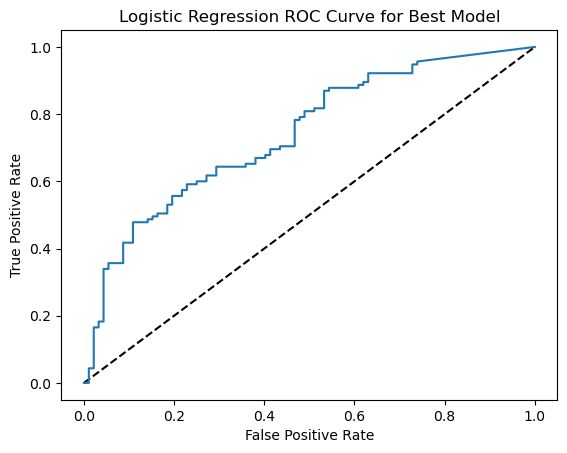

[[72 20]
 [20 95]]


In [66]:
#To evaluate performance of my logistic regression model, I can plot ROC curve
#use predicted probabilities for the positive class on the TEST set
y_test_proba = best_model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test,y_test_proba)

plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr,tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve for Best Model')
plt.show()


# confusion matrix on test set
y_test_pred = best_model.predict(X_test_scaled)
print(confusion_matrix(y_test, y_test_pred))